In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'DKK=X'
numbers_in_currency = 'USD'
share_name = 'MAERSK-B.CO'

# 1.2. Raw input statement data

In [3]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

## (OPTIONAL) Time Filtering - Last 7 years daat

In [4]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-03-31,11736,0,11736,1207,4654,6896,1298,19182,0,...,76525,0,0,3164,16542,11696,34110,1874,-2113,21.98
1,2014-06-30,11949,0,11949,2304,3411,7147,1307,13306,0,...,70972,0,0,2735,11262,11272,28498,1749,-1908,21.98
2,2014-09-30,12169,0,12169,1495,5163,6928,1305,14340,0,...,72489,0,0,2690,11880,11609,29428,2722,-2698,21.98
3,2014-12-31,11715,0,11715,189,3507,4077,1139,16225,0,...,68844,0,0,1412,9602,10913,26619,2416,-1911,21.98
4,2015-03-31,10547,0,10547,1572,3078,11036,1034,16103,0,...,69001,0,0,1336,15627,10369,32053,1950,-1985,21.55


## Calculate date when quaterly reports could be available

In [5]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [6]:
data = utils.filter_raw_data(data)

## Pull historical average USD national currency rates and add to the dataframe

In [7]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

## Convert USD values related to IS, BS, CFS to national currency

In [8]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,18.71,129997.248178,0.0,129997.248178,36336.492322,73366.011500,199817.880181,11701.211340,...,683397.430375,0.0,0.0,23978.729223,97176.955274,27531.403739,216581.835081,59943.175549,-6529.042487,7.295020
36,2023-03-31,2023-04-21,17.57,98548.866735,0.0,98548.866735,16113.818359,80825.747532,131872.492820,10273.166160,...,593013.487516,0.0,0.0,22453.908751,103654.234928,25485.221115,213218.488470,36895.996492,-5812.905633,6.936642
37,2023-06-30,2023-07-21,17.57,88859.896382,0.0,88859.896382,10173.596082,71310.956266,133939.805317,10146.229314,...,571281.286407,0.0,0.0,20737.168612,85185.907749,25184.268446,192716.781743,18972.012062,-5049.168735,6.841692
38,2023-09-30,2023-10-21,17.57,83060.442629,0.0,83060.442629,3793.839988,52250.900920,153910.746812,12114.265233,...,571534.461320,0.0,0.0,20338.817265,87785.622397,27597.789083,195752.556067,9477.751884,-5608.582943,6.848087
39,2023-12-31,2024-02-11,17.57,81406.557563,0.0,81406.557563,-3161.688974,46461.574161,144723.539392,11495.790174,...,569242.685963,0.0,0.0,19739.755505,85913.351057,28905.880119,194624.143666,832.023414,-8673.844094,6.933528


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [9]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [10]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [11]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [12]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-21,6208.251953,2014-03-31,63910.48745,1196.166409,10508.574618,21.98,86847.686934,3951.214146,25344.189553,...,0.554263,0.445737,6.807425,0.0,10.086807,-0.0,1.0,0.102846,0.06309,0.113828
1,2014-04-28,6490.216309,2014-03-31,63910.48745,1196.166409,10508.574618,21.98,86847.686934,3951.214146,25344.189553,...,0.554263,0.445737,6.807425,0.0,10.086807,-0.0,1.0,0.102846,0.06309,0.113828
2,2014-05-05,6470.076172,2014-03-31,63910.48745,1196.166409,10508.574618,21.98,86847.686934,3951.214146,25344.189553,...,0.554263,0.445737,6.807425,0.0,10.086807,-0.0,1.0,0.102846,0.06309,0.113828
3,2014-05-12,6646.303711,2014-03-31,63910.48745,1196.166409,10508.574618,21.98,86847.686934,3951.214146,25344.189553,...,0.554263,0.445737,6.807425,0.0,10.086807,-0.0,1.0,0.102846,0.06309,0.113828
4,2014-05-19,7049.109375,2014-03-31,63910.48745,1196.166409,10508.574618,21.98,86847.686934,3951.214146,25344.189553,...,0.554263,0.445737,6.807425,0.0,10.086807,-0.0,1.0,0.102846,0.06309,0.113828


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [13]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-21,6208.251953,2014-03-31,63910.48745,1196.166409,10508.574618,21.98,86847.686934,3951.214146,25344.189553,...,-0.0,1.0,0.102846,0.06309,0.113828,5.190124,0.590780,0.533783,1.161254,1.571226
1,2014-04-28,6490.216309,2014-03-31,63910.48745,1196.166409,10508.574618,21.98,86847.686934,3951.214146,25344.189553,...,-0.0,1.0,0.102846,0.06309,0.113828,5.425847,0.617611,0.558026,1.185497,1.642588
2,2014-05-05,6470.076172,2014-03-31,63910.48745,1196.166409,10508.574618,21.98,86847.686934,3951.214146,25344.189553,...,-0.0,1.0,0.102846,0.06309,0.113828,5.409010,0.615695,0.556295,1.183766,1.637491
3,2014-05-12,6646.303711,2014-03-31,63910.48745,1196.166409,10508.574618,21.98,86847.686934,3951.214146,25344.189553,...,-0.0,1.0,0.102846,0.06309,0.113828,5.556337,0.632465,0.571447,1.198918,1.682091
4,2014-05-19,7049.109375,2014-03-31,63910.48745,1196.166409,10508.574618,21.98,86847.686934,3951.214146,25344.189553,...,-0.0,1.0,0.102846,0.06309,0.113828,5.893084,0.670796,0.606080,1.233551,1.784036


# Calculate Dividend yield and currency-share price correlation

In [14]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

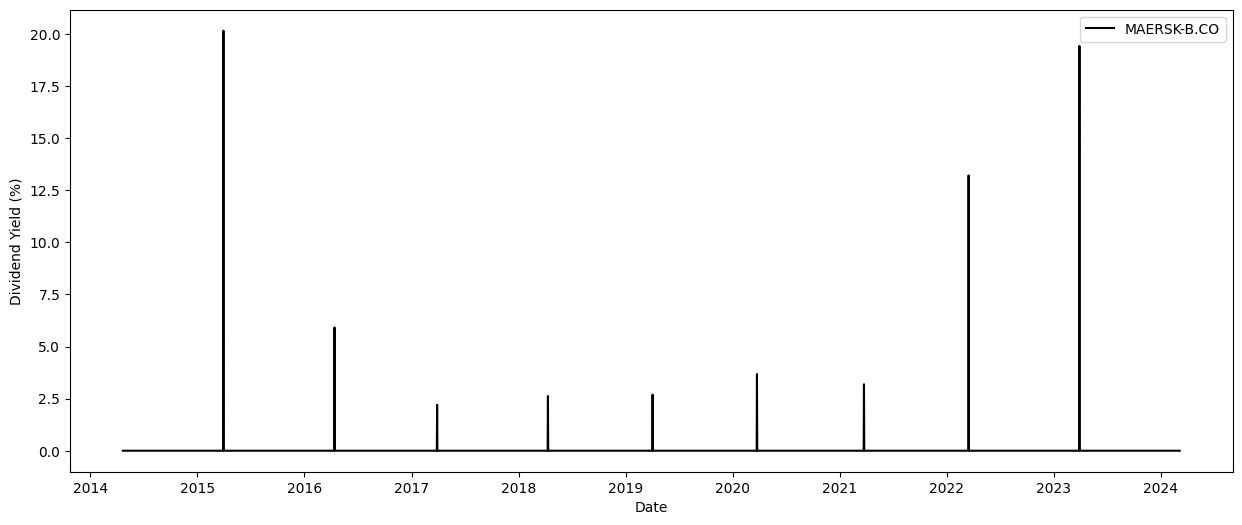

In [15]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.266021
share_price      1.000000
Name: share_price, dtype: float64


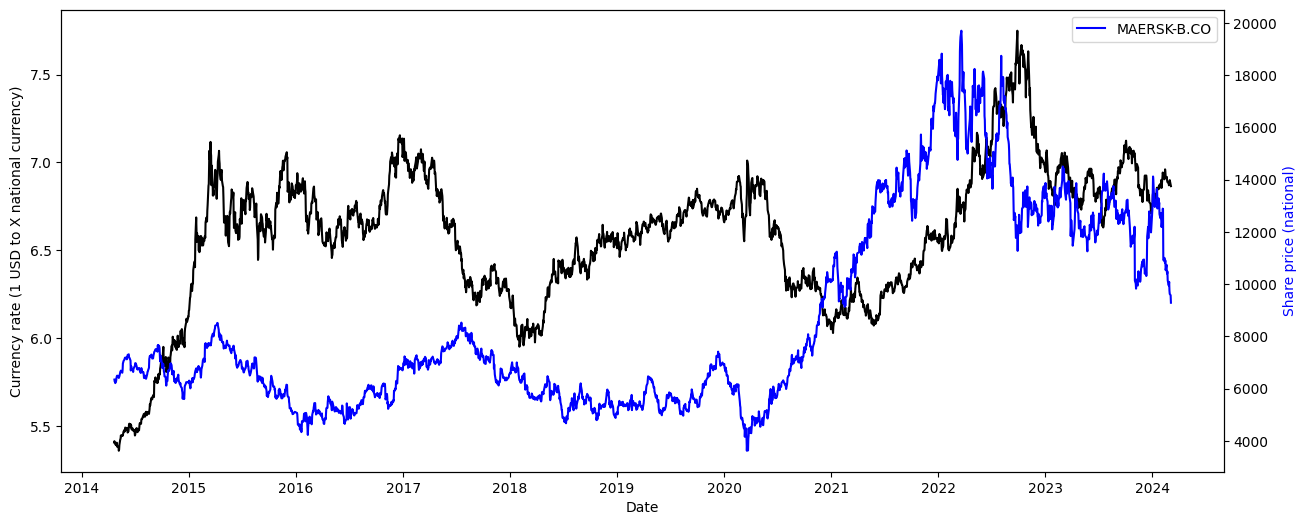

In [16]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

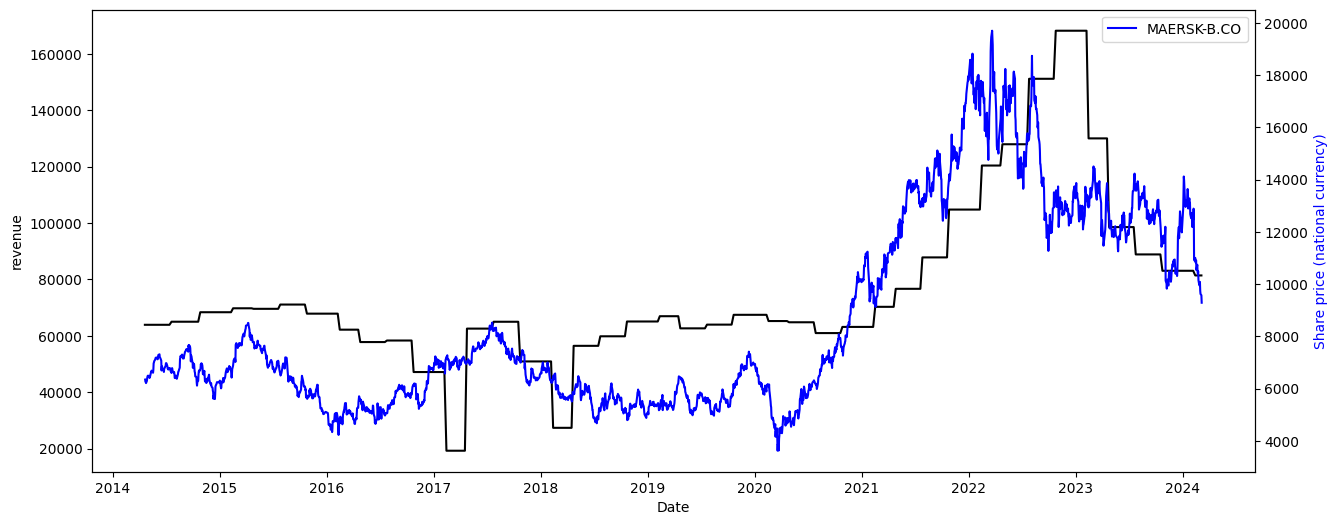

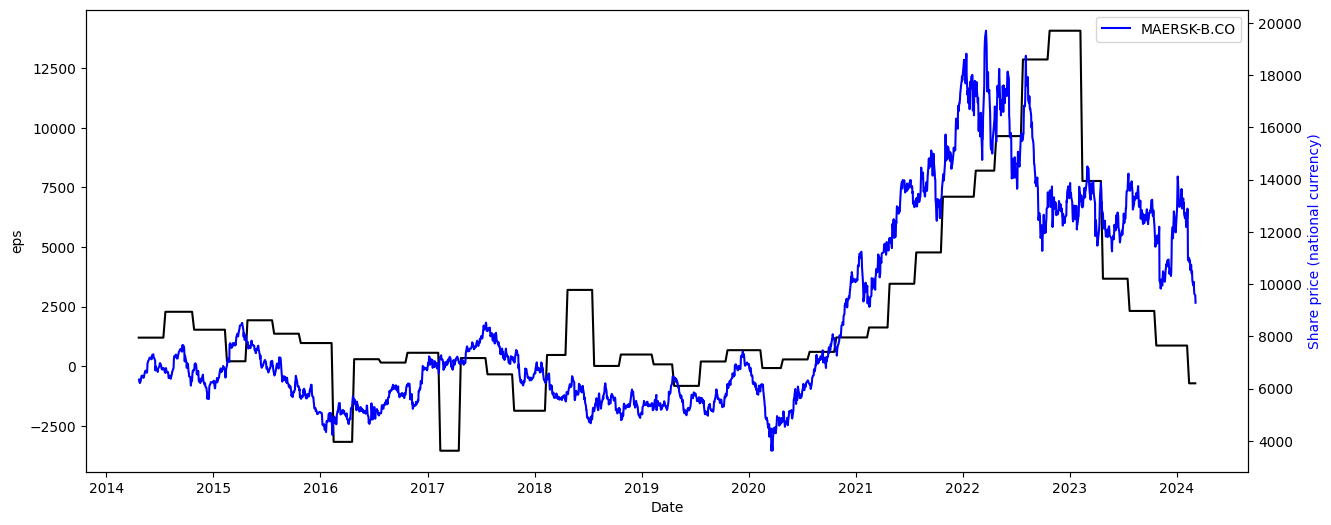

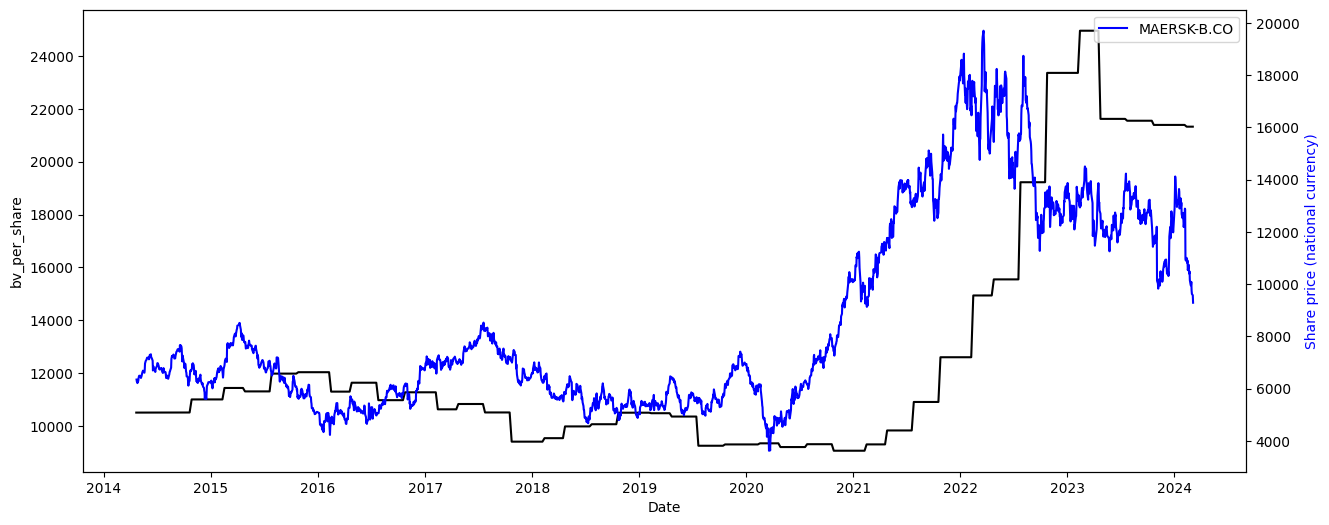

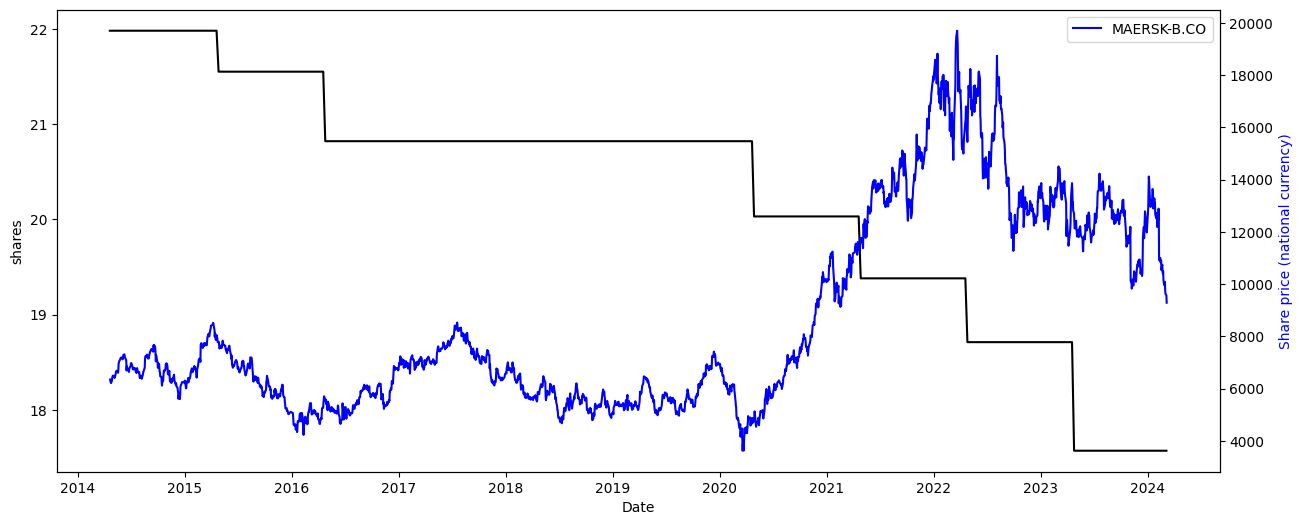

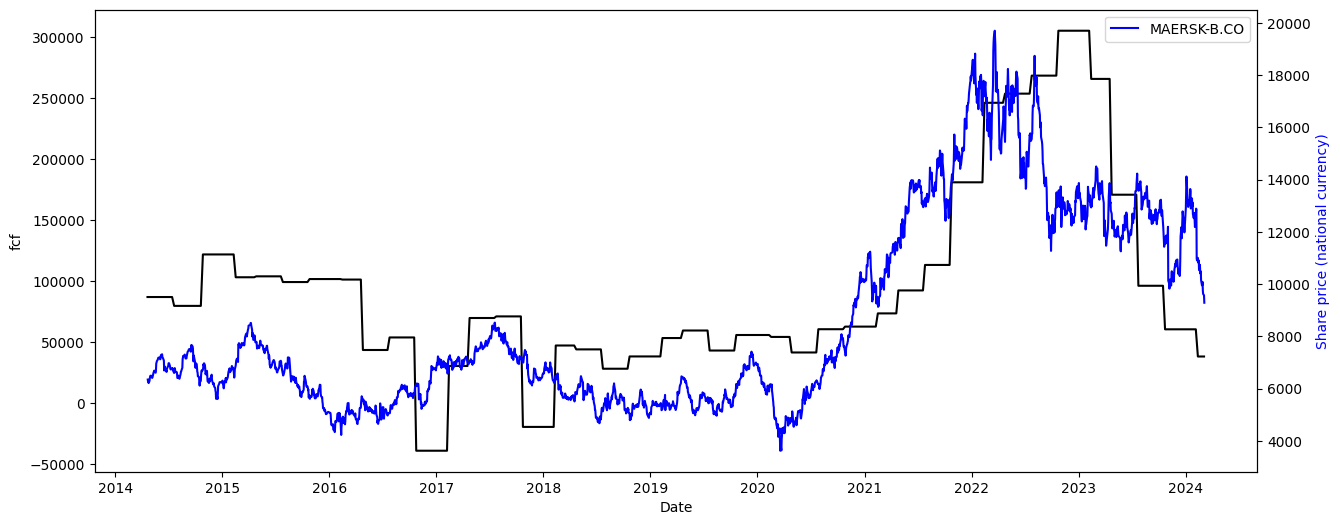

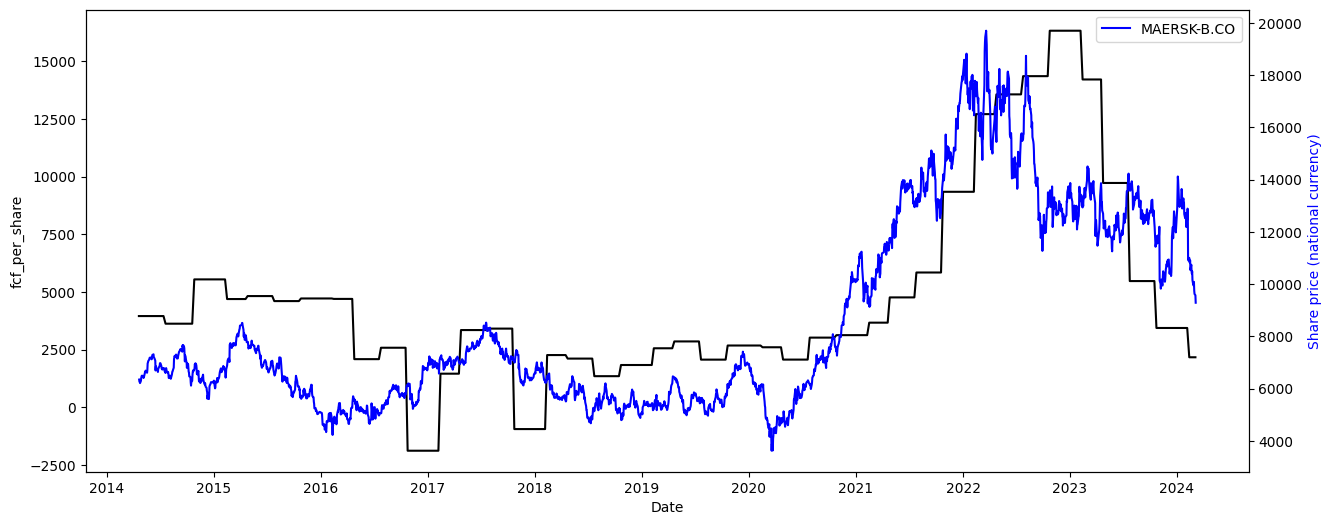

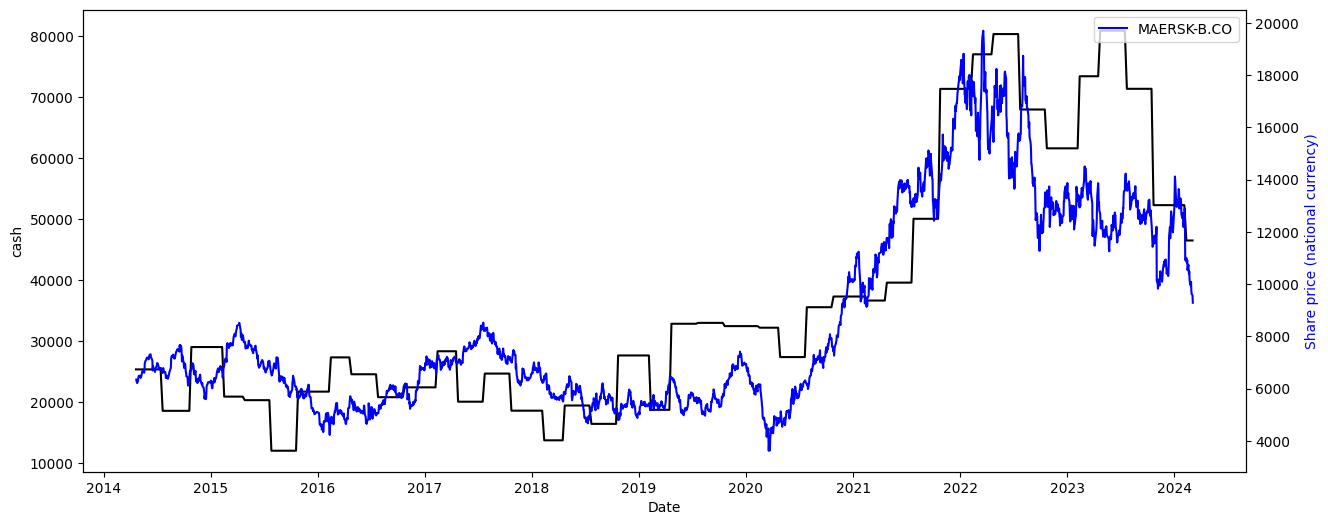

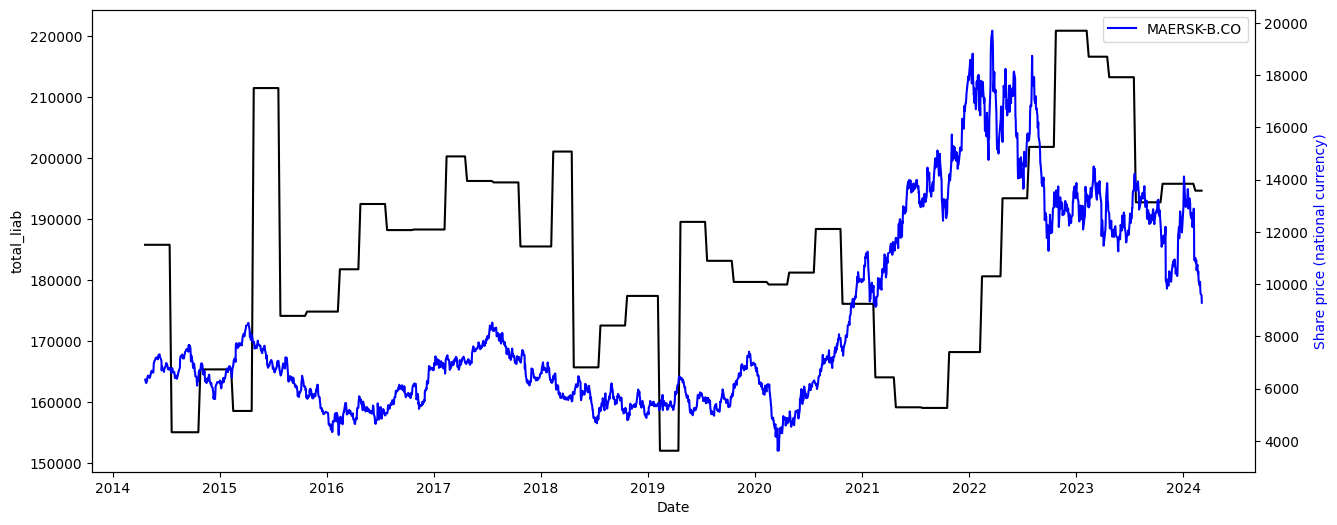

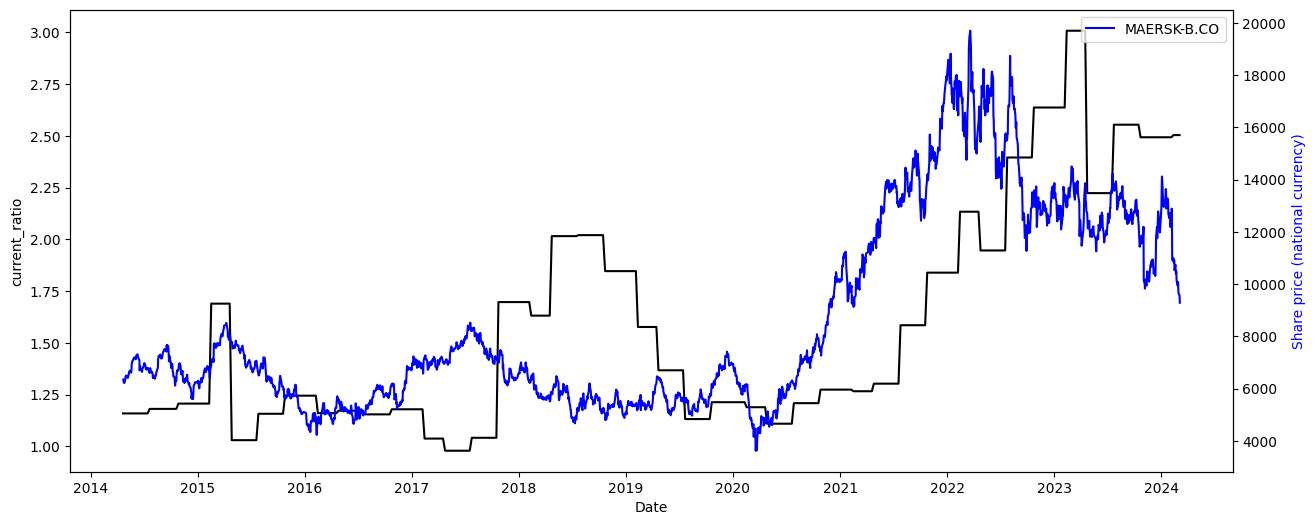

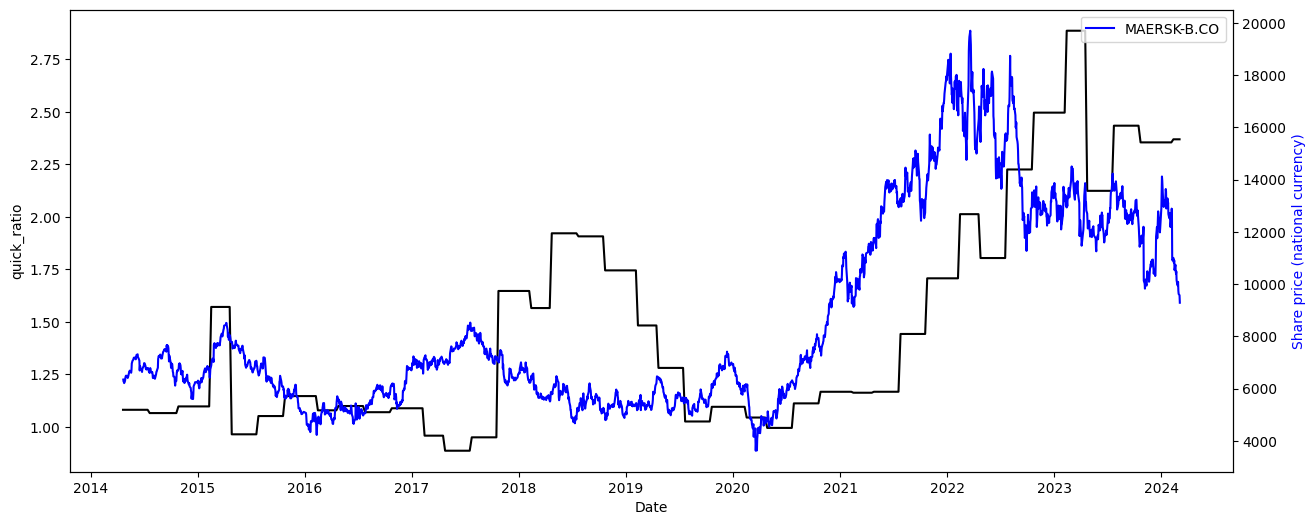

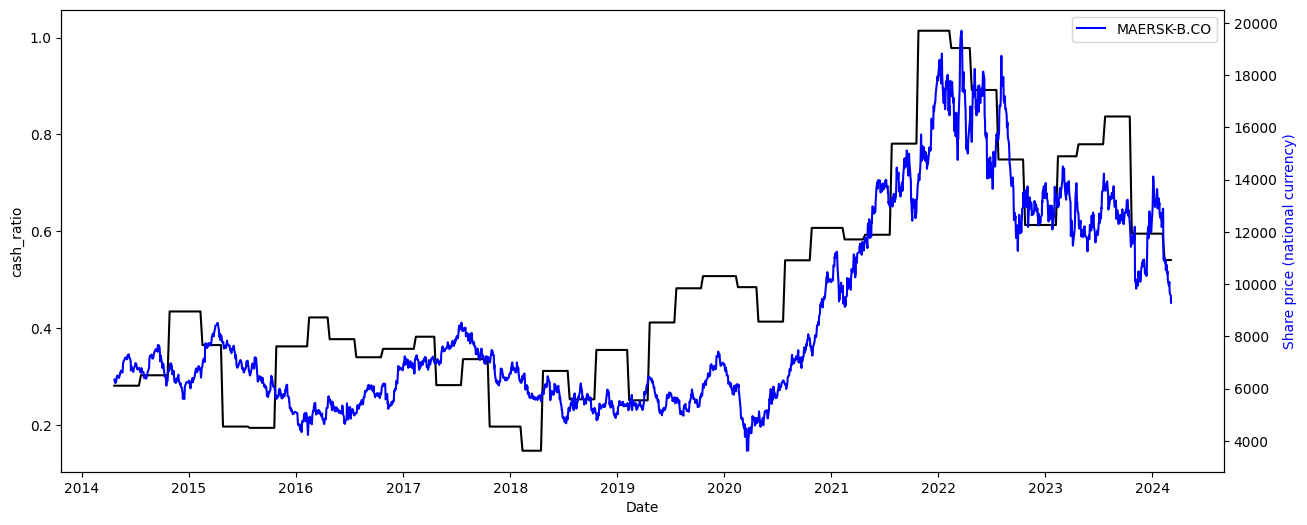

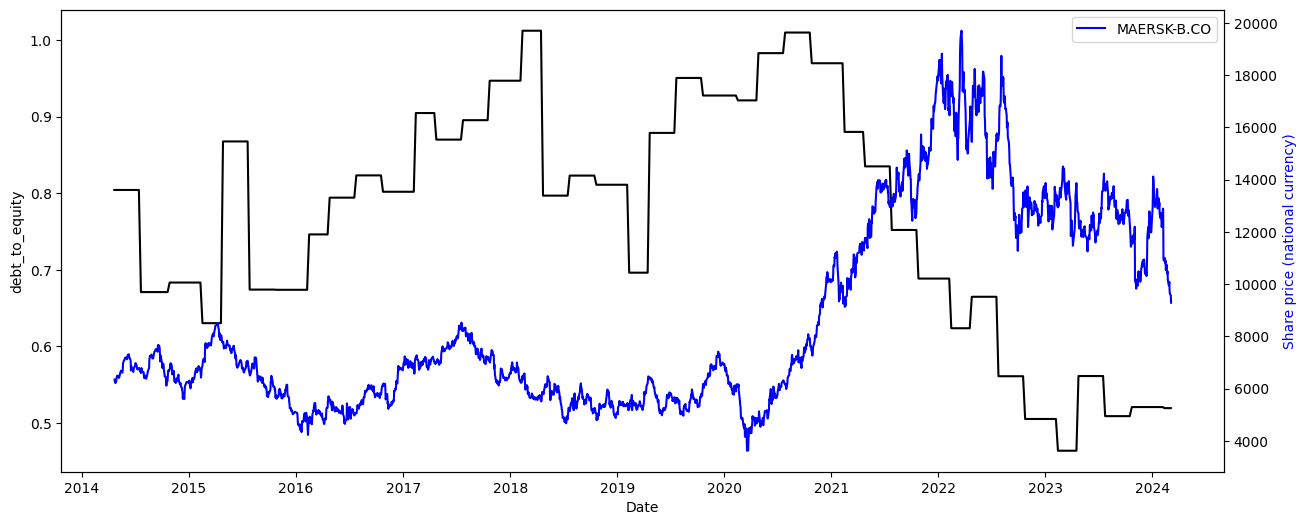

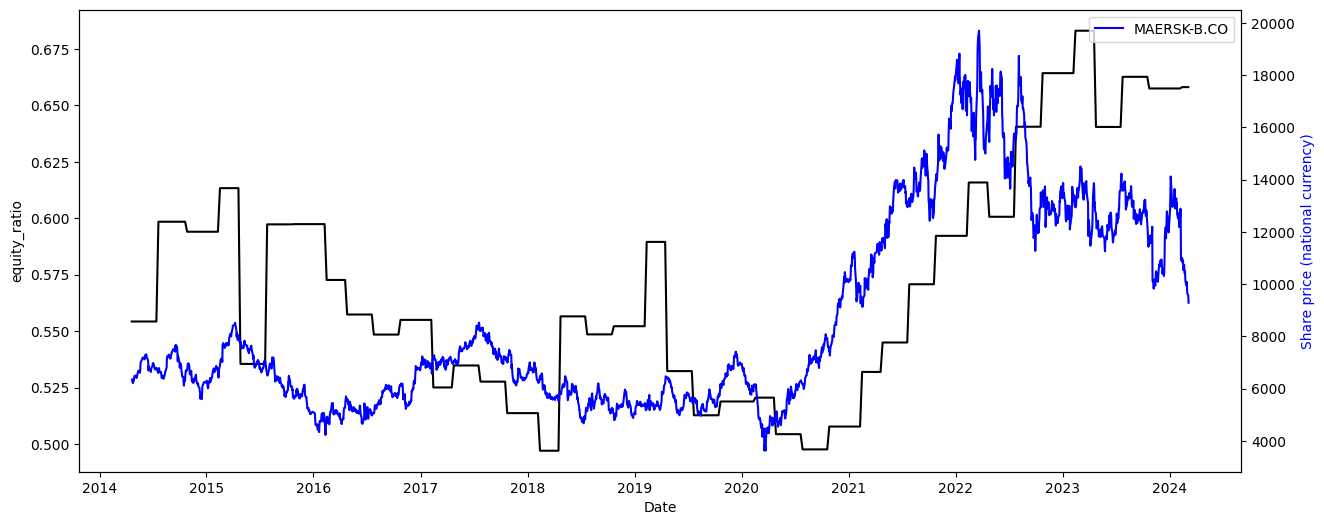

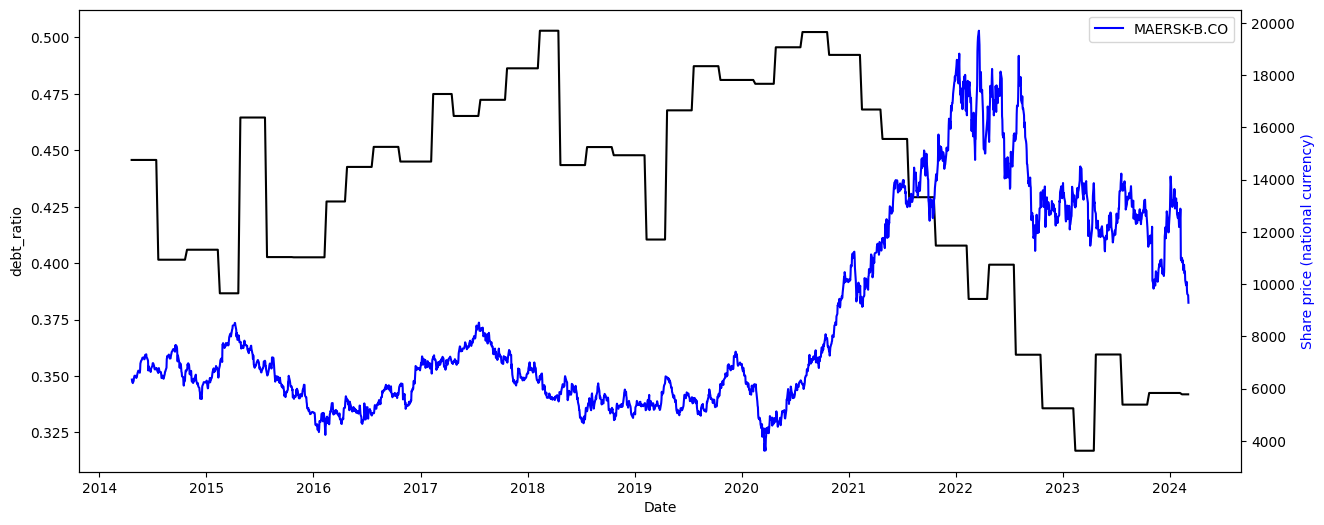

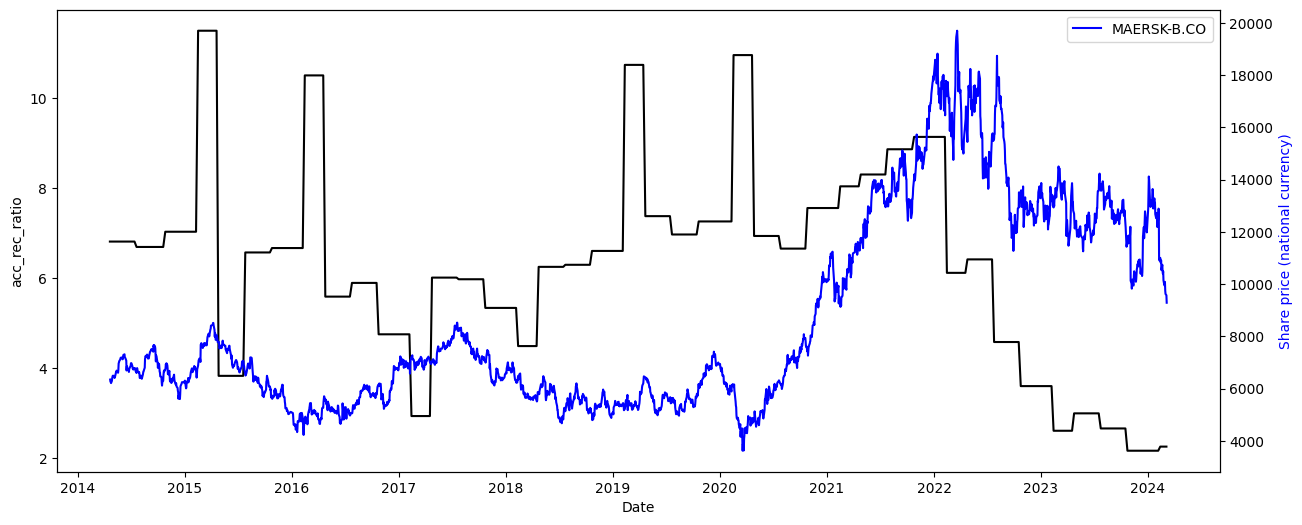

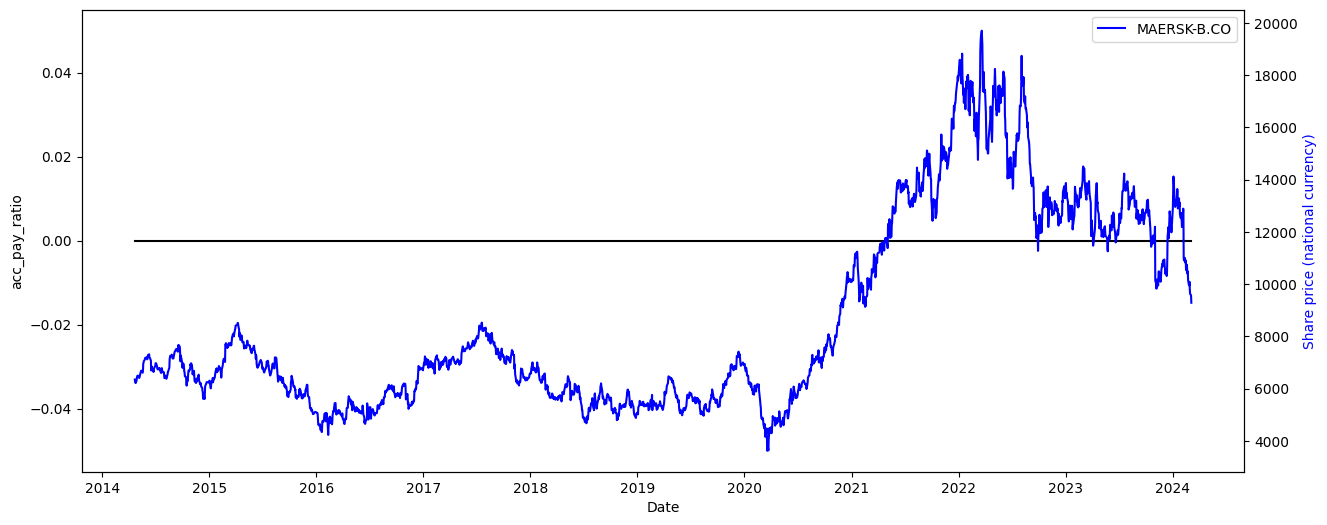

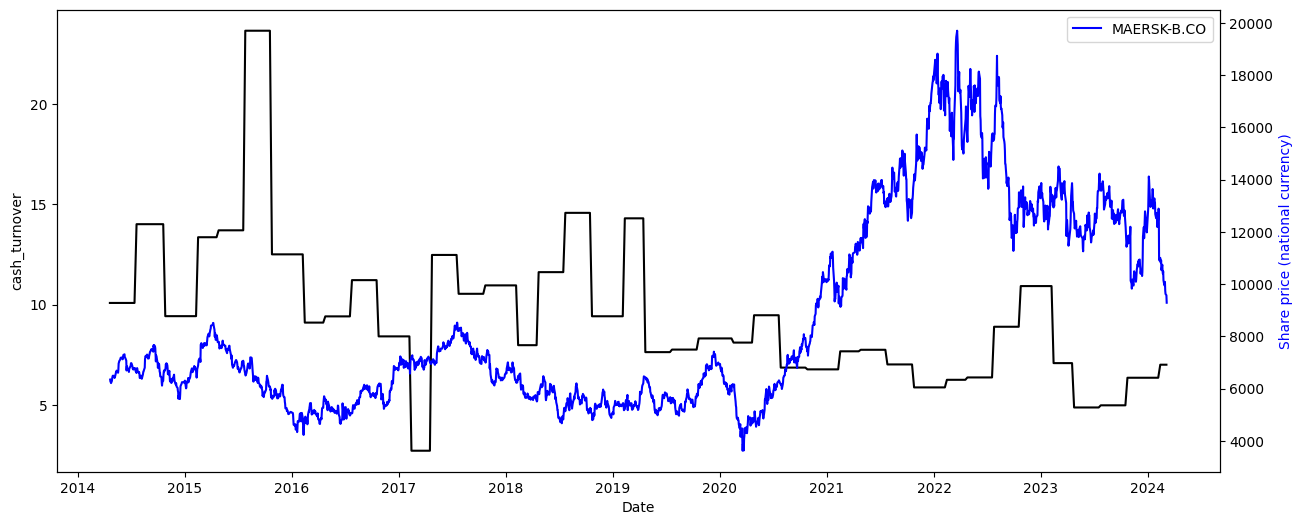

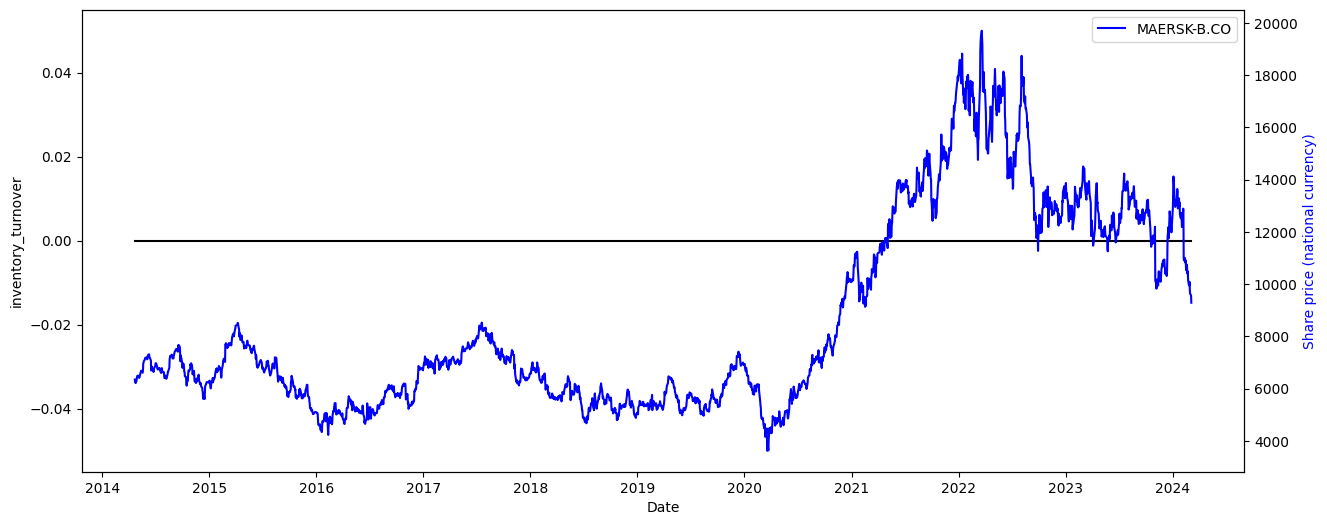

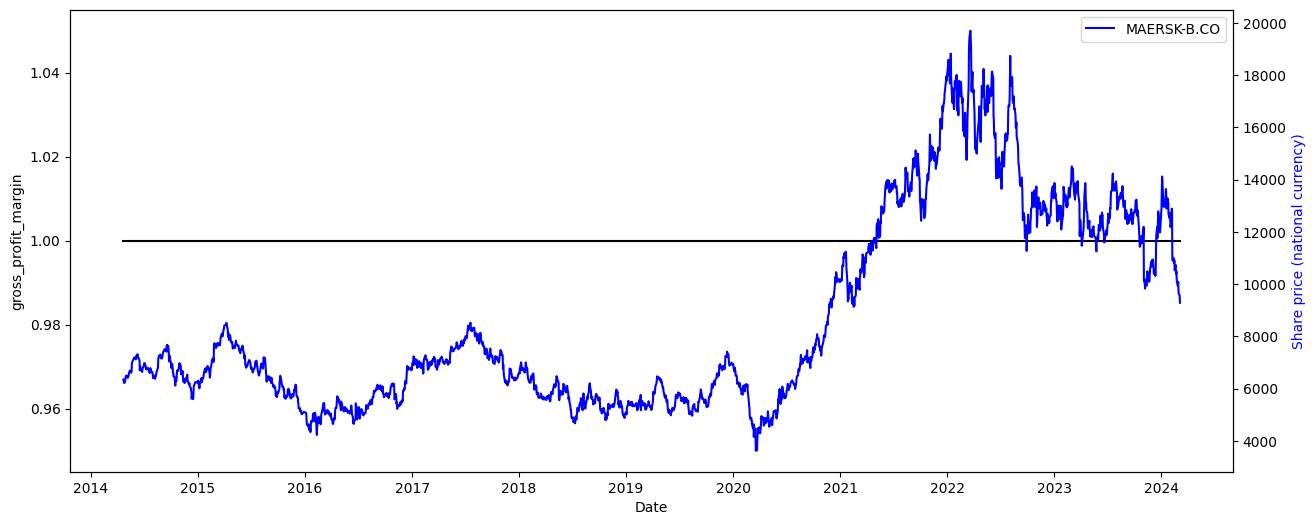

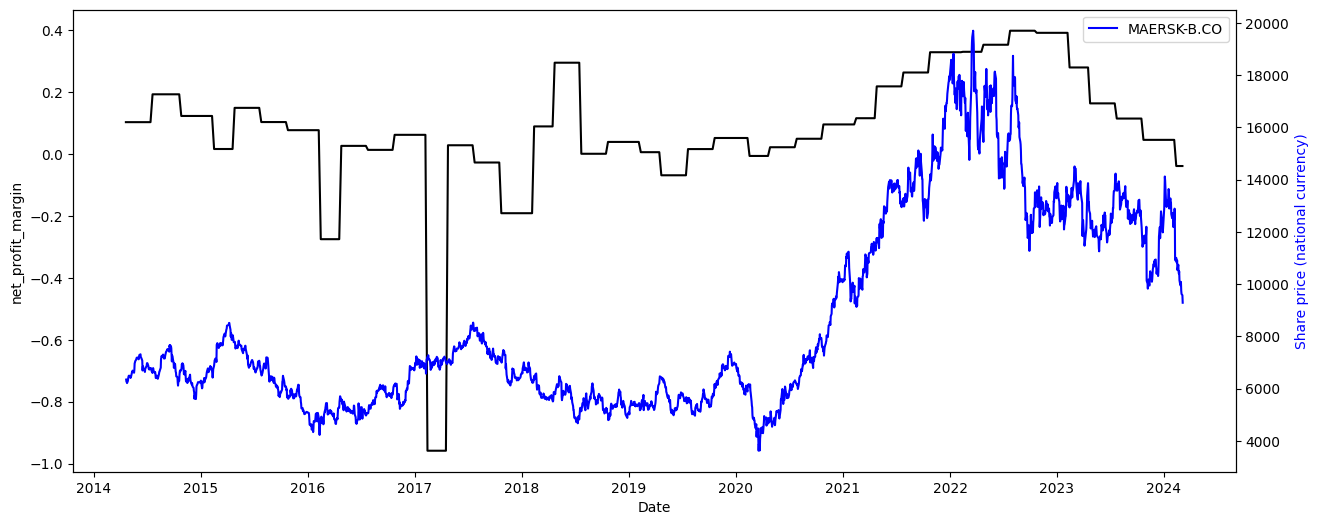

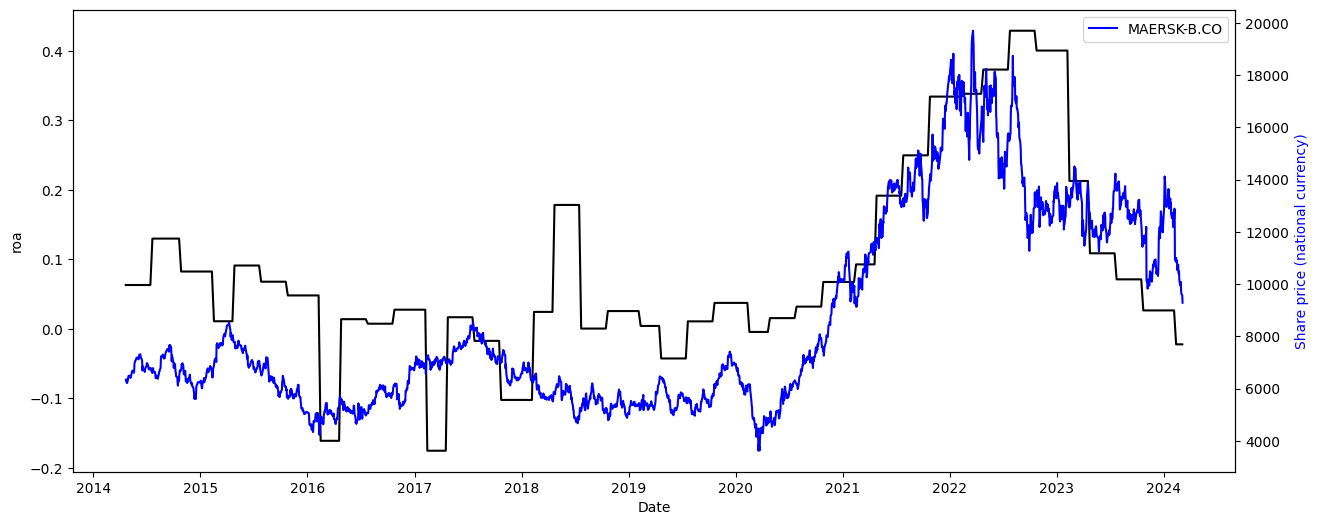

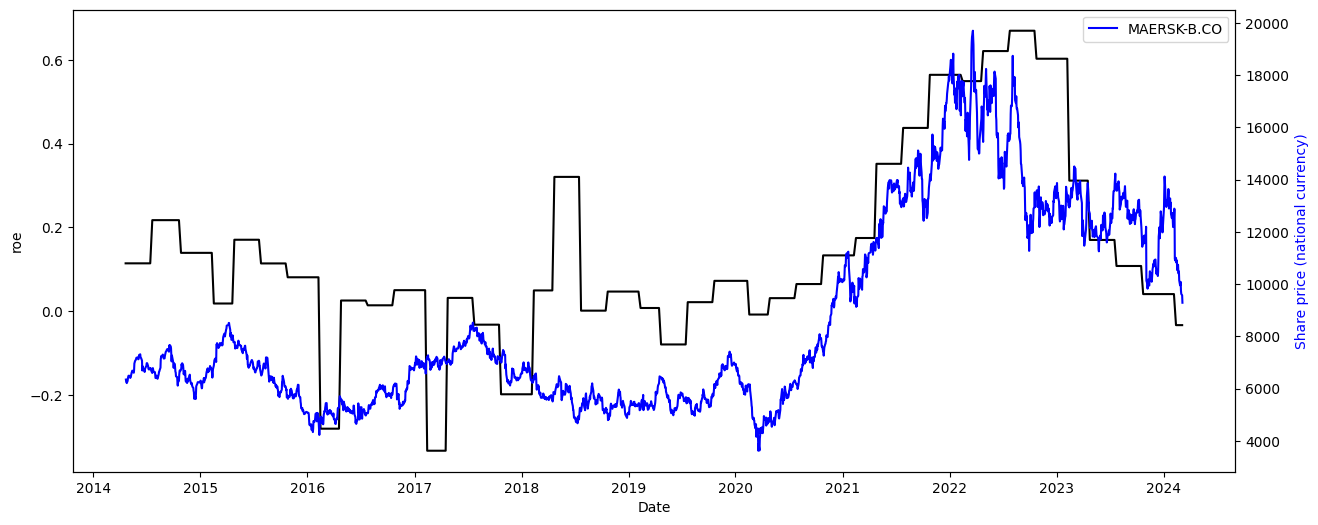

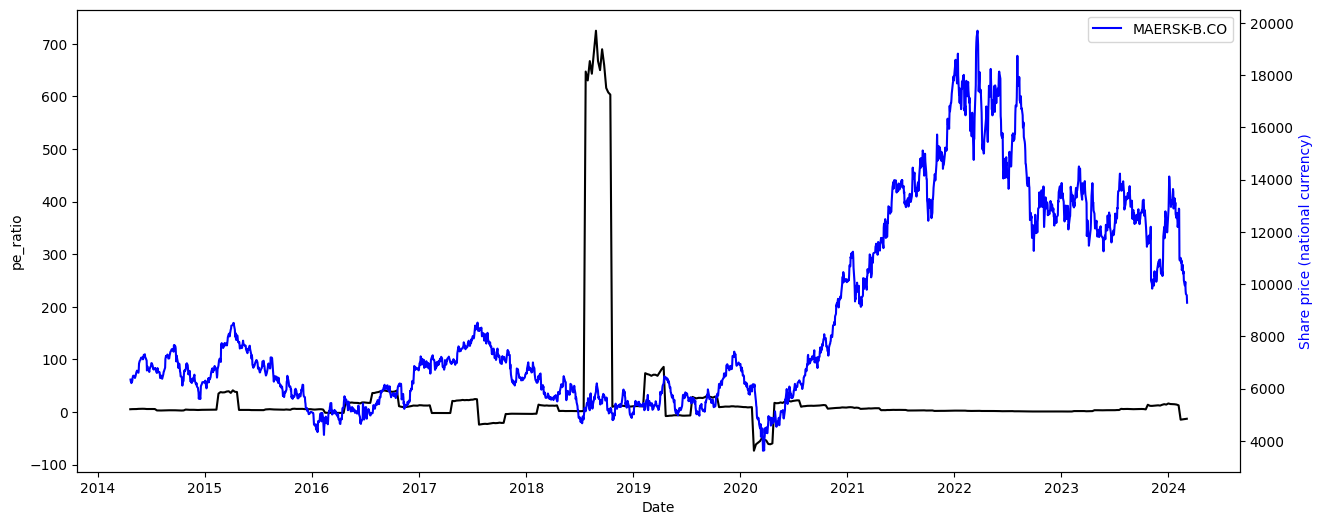

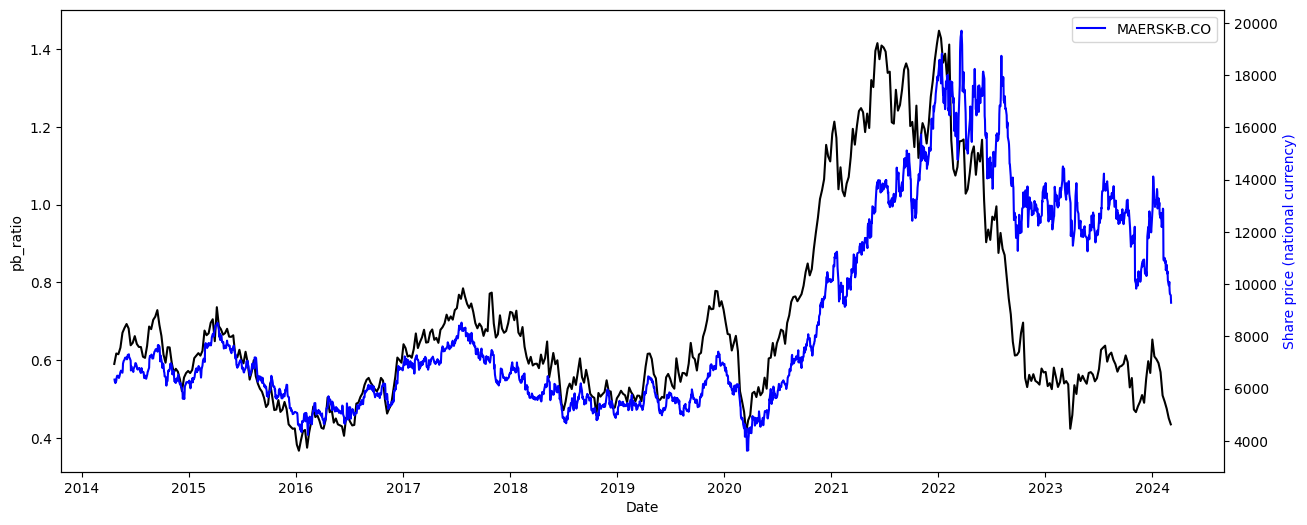

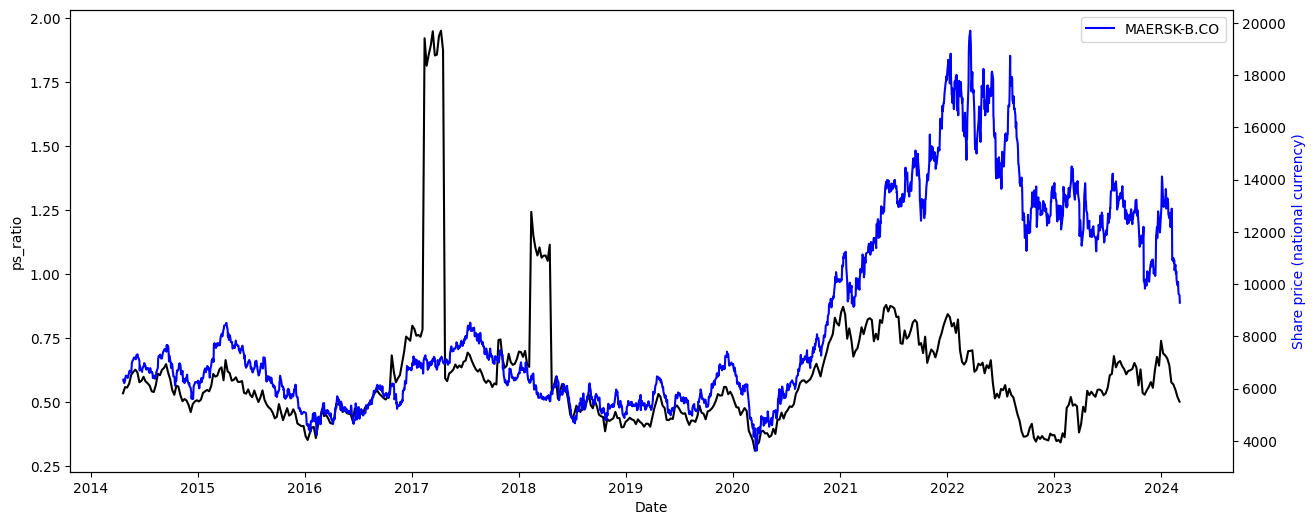

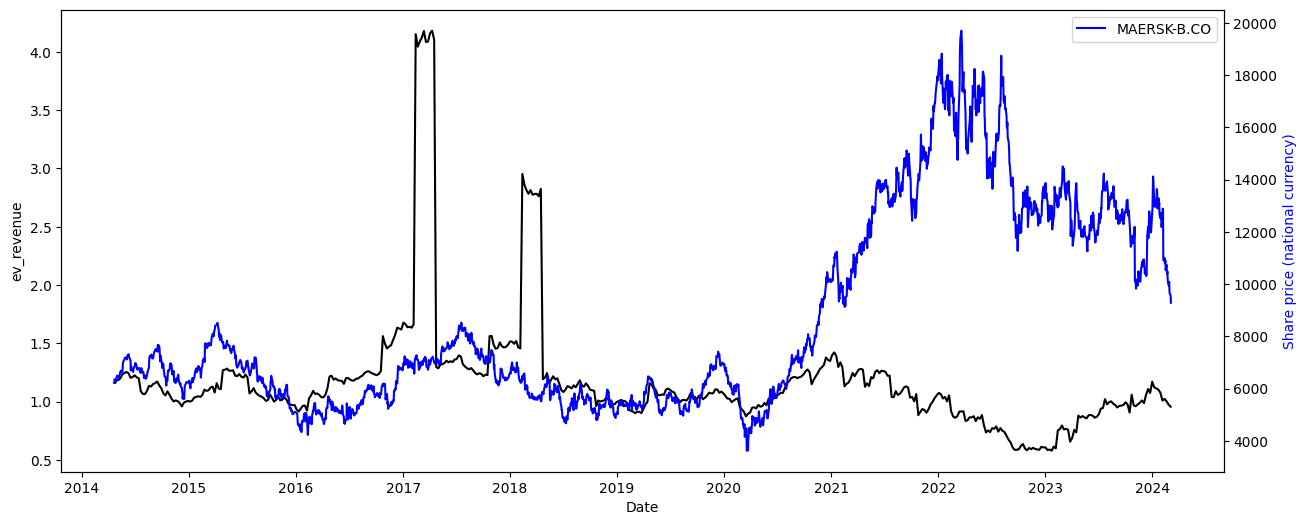

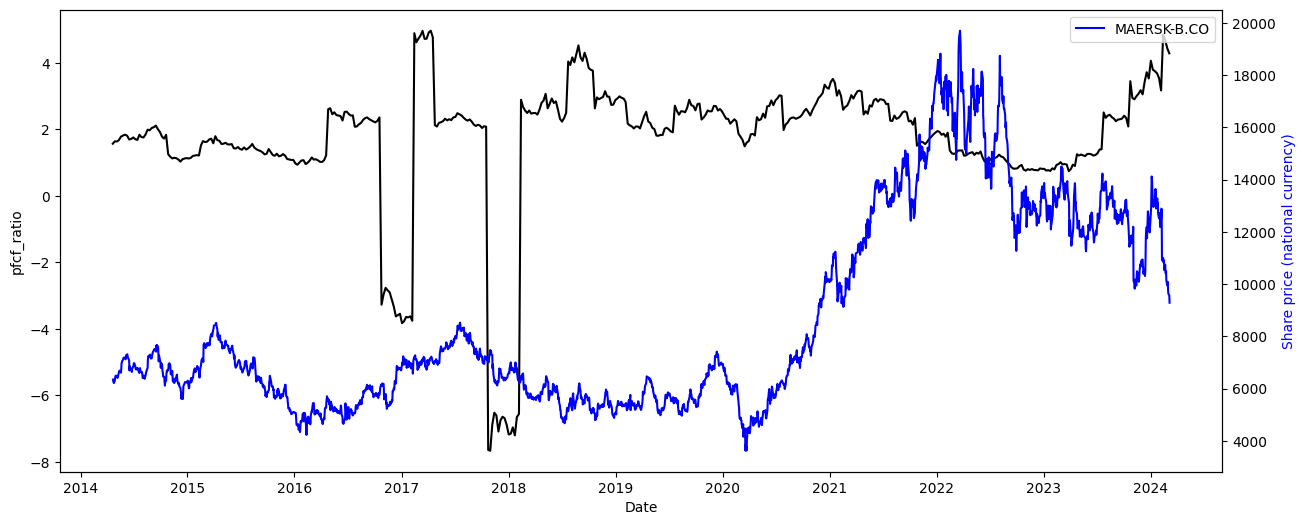

In [17]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

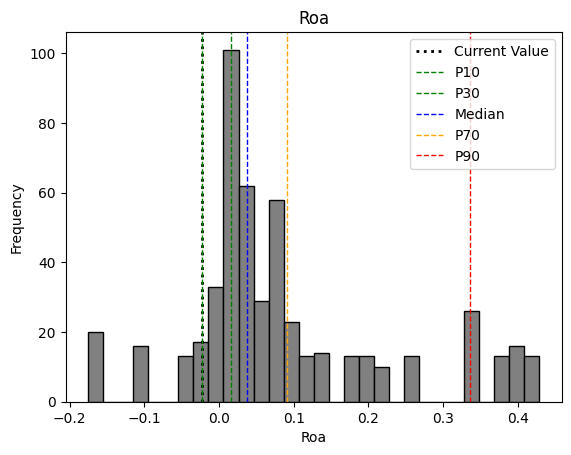

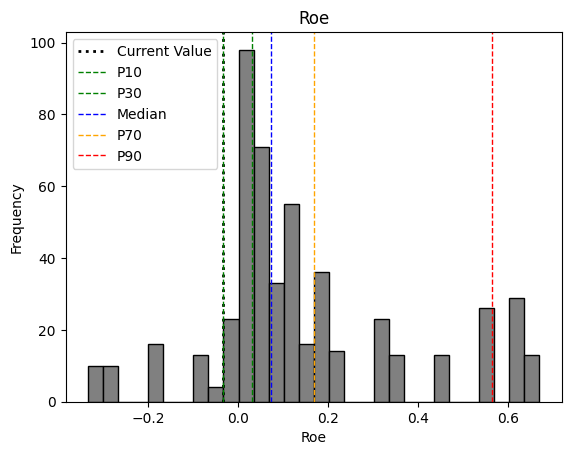

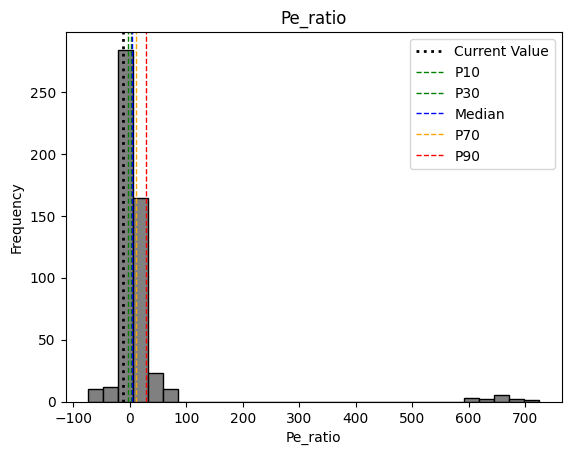

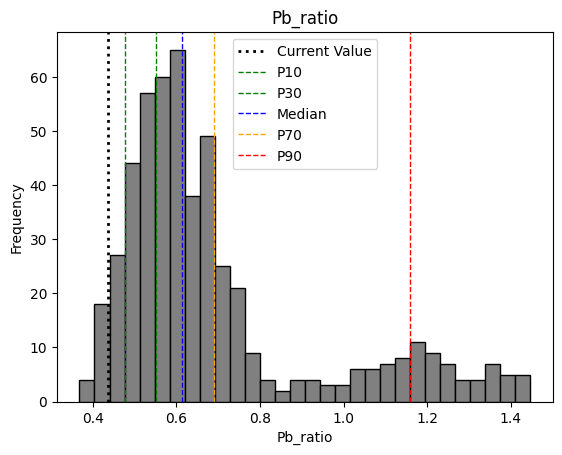

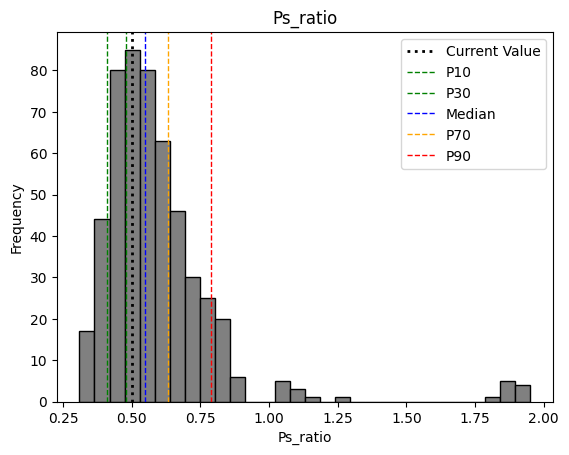

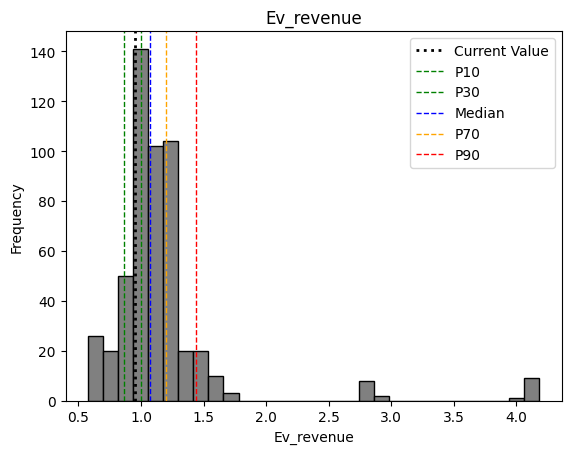

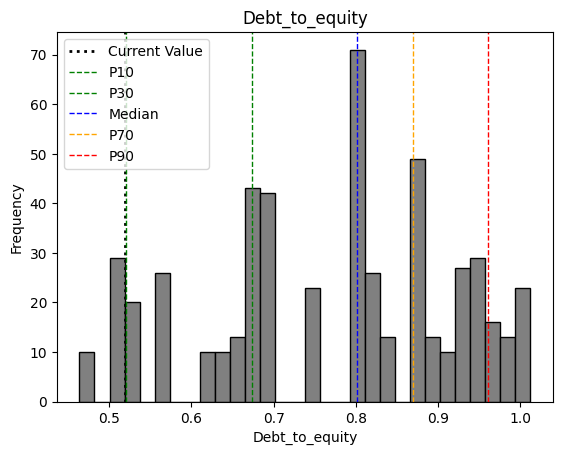

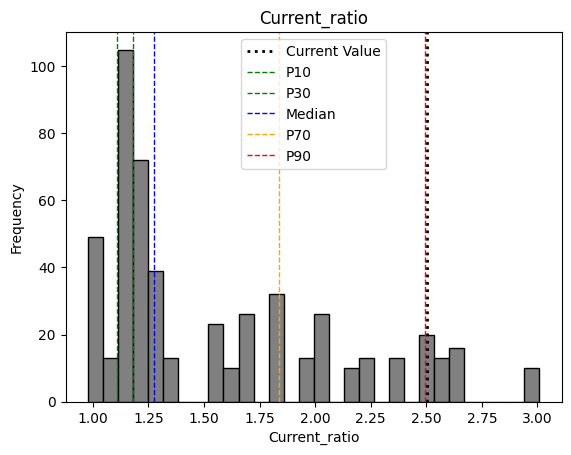

In [18]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[])

## Calculate correlation between value parameters

In [19]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.996427,-0.114701,0.482937,-0.171452,-0.470418,-0.520292,0.518656
roe,0.996427,1.000000,-0.112635,0.517971,-0.171813,-0.476391,-0.486564,0.480372
pe_ratio,-0.114701,-0.112635,1.000000,-0.107999,-0.087152,-0.014396,0.051563,0.123891
pb_ratio,0.482937,0.517971,-0.107999,1.000000,0.390625,0.002493,0.108345,-0.017412
ps_ratio,-0.171452,-0.171813,-0.087152,0.390625,1.000000,0.886277,0.238369,-0.154293
ev_revenue,-0.470418,-0.476391,-0.014396,0.002493,0.886277,1.000000,0.443356,-0.338920
debt_to_equity,-0.520292,-0.486564,0.051563,0.108345,0.238369,0.443356,1.000000,-0.727742
current_ratio,0.518656,0.480372,0.123891,-0.017412,-0.154293,-0.338920,-0.727742,1.000000


0 timestemos have been found!


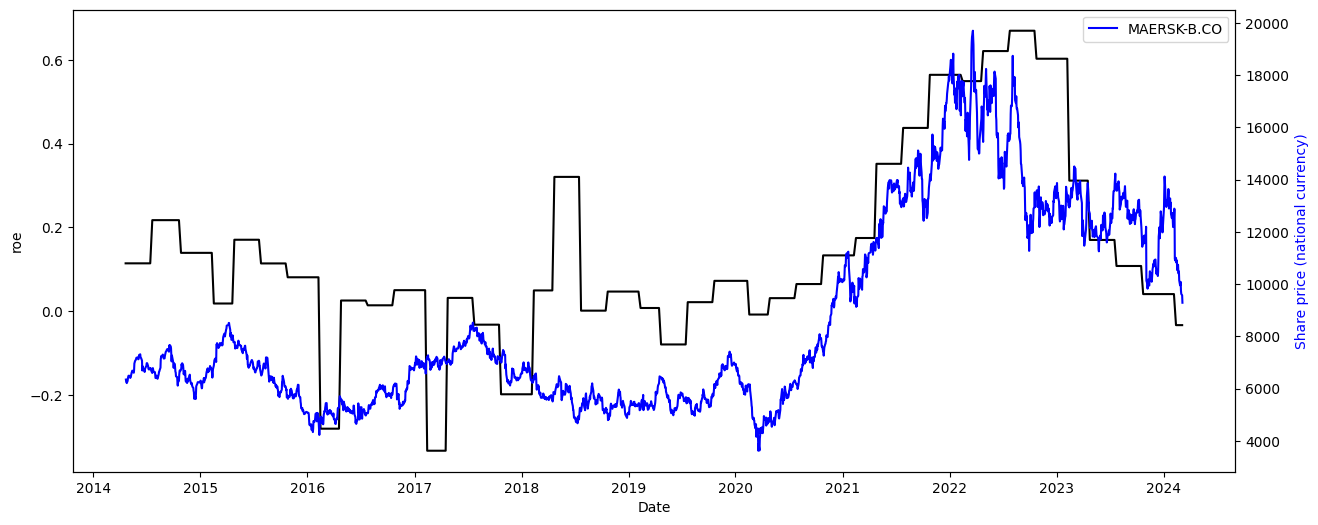

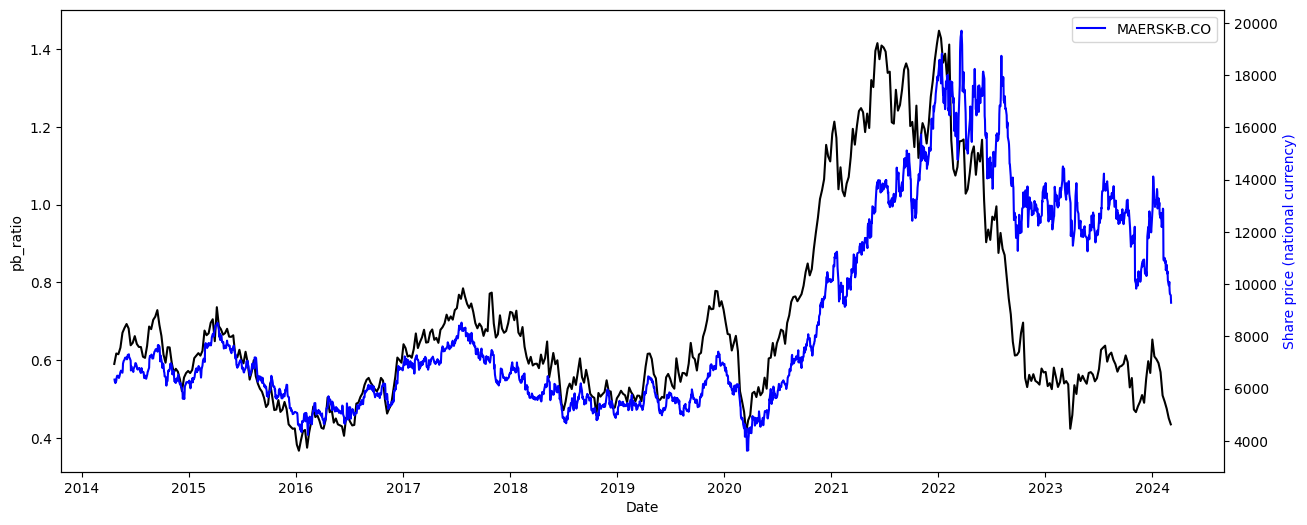

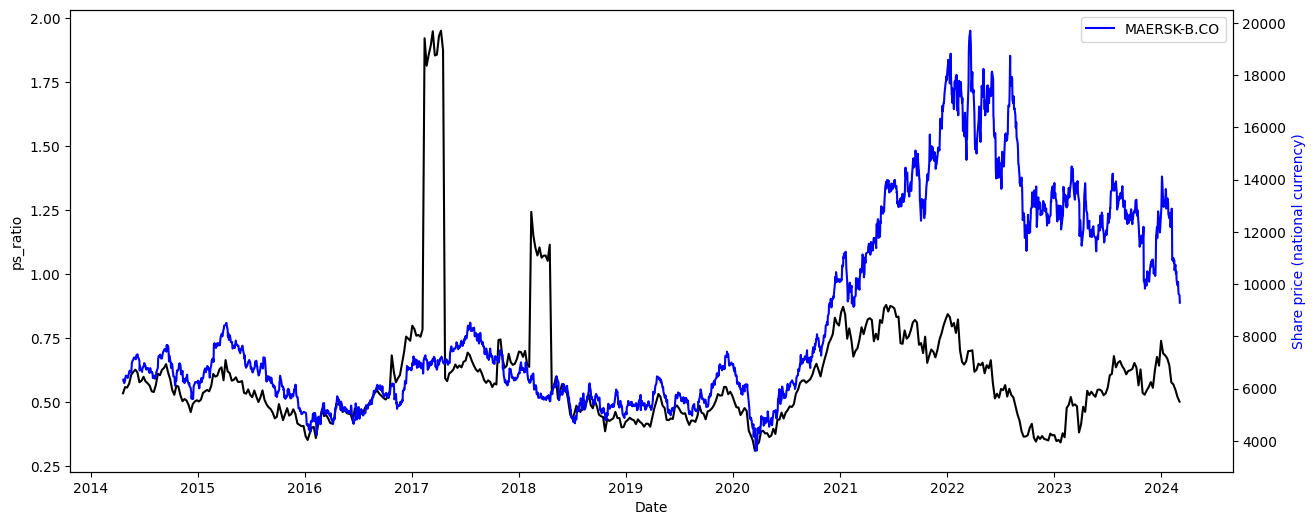

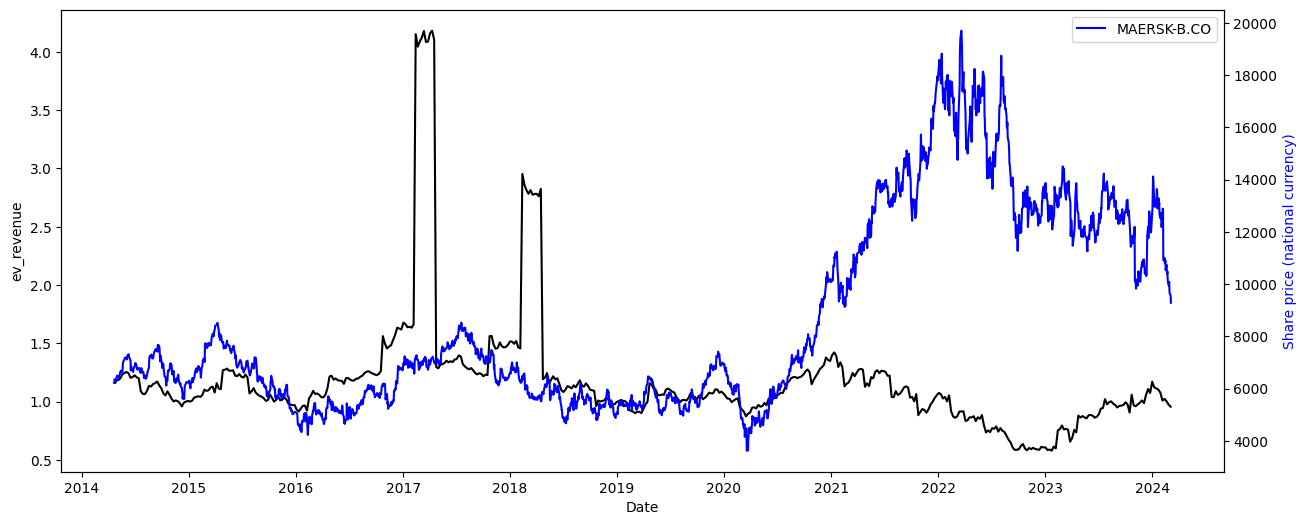

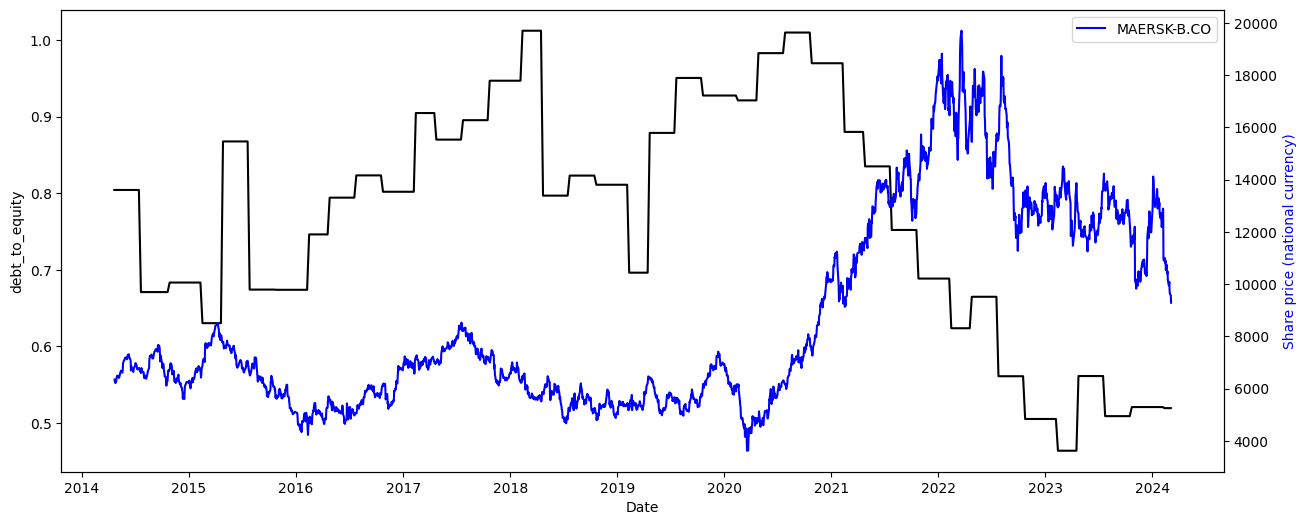

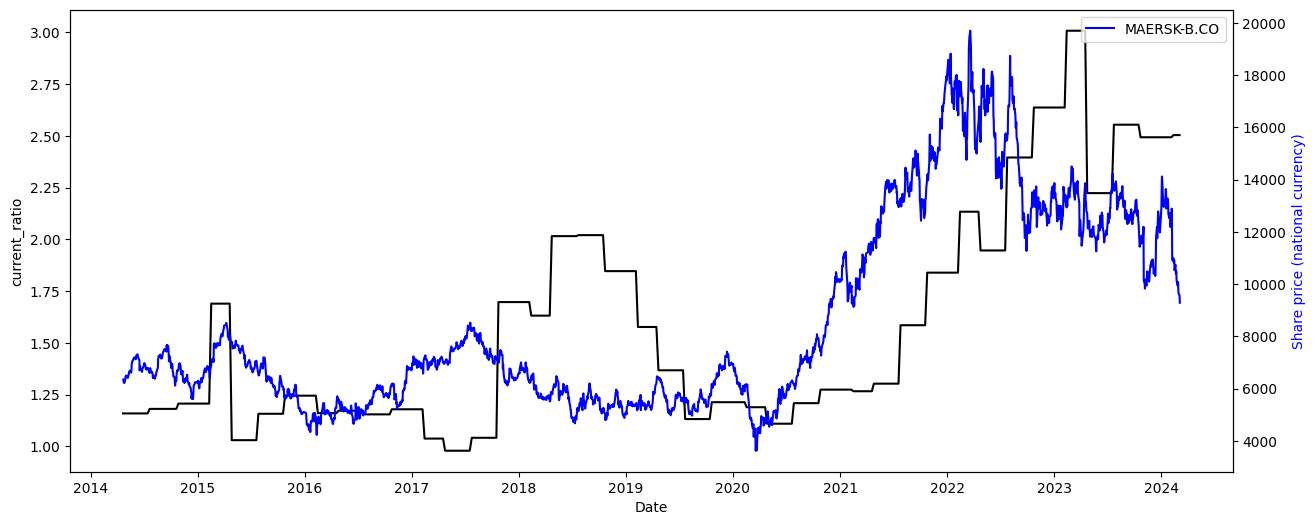

In [20]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2
    )